In [4]:
import pandas as pd
import os
from matplotlib import pyplot as plt

In [10]:
station_id = 'USW00013740'
output_dir = 'ghcn_data'
os.environ["DLY_OUTPUT"] = output_dir

station_id_list = ['USW00013740'] # only RIC

In [30]:
# expects the files in output_dir populated by 'weather.ipynb'

# create a blank df using the columns from the first csv
sdf = pd.read_csv(output_dir + '/' + station_id_list[0] + '.csv', nrows=0)

# load all the files into one df
for s in station_id_list:
    df = pd.read_csv(output_dir + '/' + s + '.csv')
    sdf = sdf.append(df)

/home/kfinity/anaconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (14,24,26,48,50,52,56,58,62,64,66,68,70,72,74,76,78,80,82,84,86,88,90,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [31]:
# fix date column
sdf['DAY'] = pd.to_datetime(sdf['MM/DD/YYYY'], format='%Y-%m-%d')

# for this, we want TAVG column - avg temp

# convert TMIN/TMAX/TAVG from "tenths of degrees C" to F
sdf['TMIN'] = (sdf['TMIN'] /10 * 9/5) +32
sdf['TMAX'] = (sdf['TMAX'] /10 * 9/5) +32
sdf['TAVG'] = (sdf['TAVG'] /10 * 9/5) +32

# drop columns
sdf = sdf.loc[:,['DAY','ID','YEAR','MONTH','TAVG','TMIN','TMAX']]

# day of year
sdf['DOY'] = pd.to_numeric(sdf['DAY'].apply(lambda d: d.strftime('%j')))

sdf.head(5)

,DAY,ID,YEAR,MONTH,TAVG,TMIN,TMAX,DOY
0,1939-03-01,USW00013740,1939,3,NaN,42.08,60.08,60
1,1939-03-02,USW00013740,1939,3,NaN,28.04,42.08,61
2,1939-03-03,USW00013740,1939,3,NaN,24.08,48.92,62
3,1939-03-04,USW00013740,1939,3,NaN,30.02,48.92,63
4,1939-03-05,USW00013740,1939,3,NaN,48.02,78.98,64


In [44]:
# annual averages
ann = sdf.loc[sdf.DOY <= 365,:].groupby(['DOY']).agg({'TMIN': 'mean', 'TMAX': 'mean'}).reset_index()

In [139]:
from matplotlib.ticker import FuncFormatter
from datetime import datetime

# convert day of year to month-day string labels
def j_to_md(x, pos):
    if int(x) > 0 & int(x) < 366:
        return datetime.strptime(str(int(x)), '%j').strftime('%b %d')
    else:
        return x
    
jmd_formatter = FuncFormatter(j_to_md)

# same, but just month
def j_to_m(x, pos):
    if int(x) > 0 & int(x) < 366:
        return datetime.strptime(str(int(x)), '%j').strftime('%b')
    else:
        return x
    
jm_formatter = FuncFormatter(j_to_m)

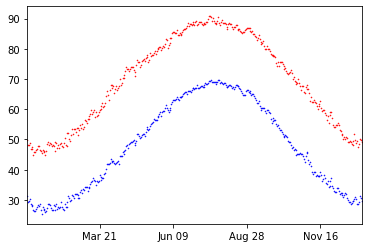

In [71]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(ann.DOY, ann.TMIN, c="blue", s=0.3)
ax1.scatter(ann.DOY, ann.TMAX, c="red", s=0.3)
ax1.set_xlim(1,365)
ax1.xaxis.set_major_locator(MaxNLocator(nbins=5,integer=True,prune="both")) #the edge ticks don't like the formatter
ax1.xaxis.set_major_formatter(jmd_formatter)

In [72]:
light = pd.read_csv('ric_sun_times.csv')

In [79]:
# combine light and temp
lt = light.set_index('day_of_year').join(ann.set_index('DOY')).reset_index()

In [137]:
# day of year - month splits
month_splits = [32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_ticks = [i+15 for i in [0] + month_splits]

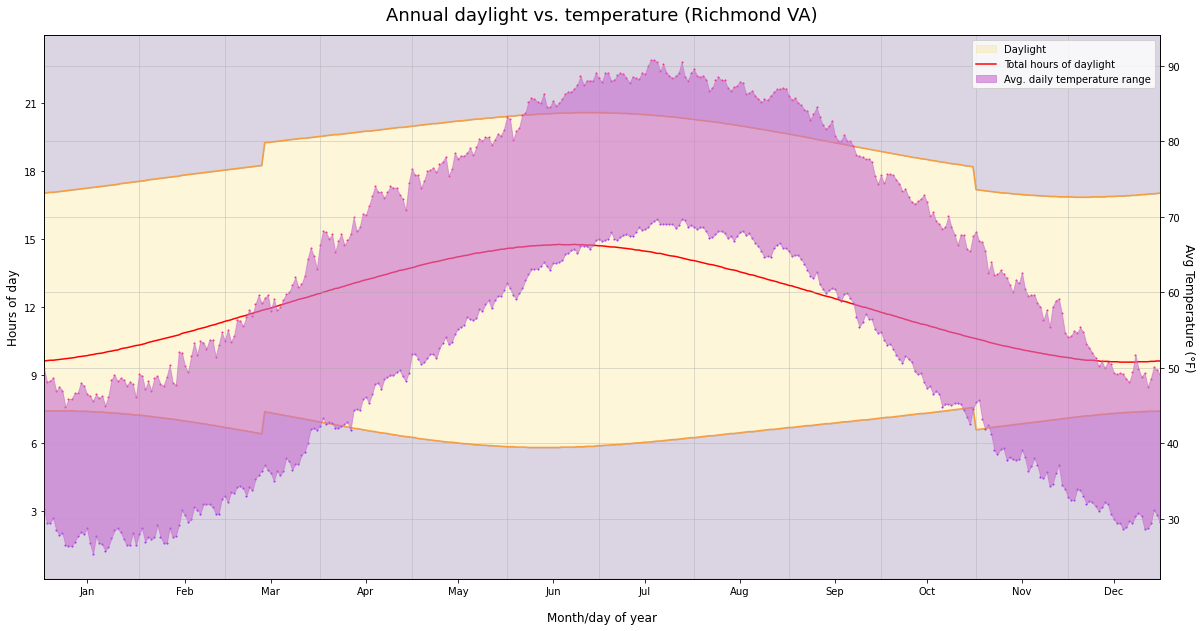

In [156]:
# 1 plot
fig, ax1 = plt.subplots(1, 1)

# set figure size in inches
fig.set_figheight(10)
fig.set_figwidth(20)

ax1.plot(lt.day_of_year, lt.sets, c="#f59e42")
ax1.plot(lt.day_of_year, lt.rises, c="#f59e42")
fill1 = ax1.fill_between(lt.day_of_year, lt.rises, lt.sets, alpha=0.2, color="#f5d442")

light1, = ax1.plot(lt.day_of_year, (lt.sets-lt.rises), c="red")

#night
ax1.fill_between(lt.day_of_year, lt.rises, 0, alpha=0.2, color="#4e2c73")
ax1.fill_between(lt.day_of_year, lt.sets, 25, alpha=0.2, color="#4e2c73")

ax1.set_yticks([3,6,9,12,15,18,21])
ax1.set_ylabel('Hours of day', fontsize=12)
ax1.set_ylim(0,24)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.scatter(lt.day_of_year, lt.TMIN, c="#8c21ff", s=1)
ax2.scatter(lt.day_of_year, lt.TMAX, c="#ff2172", s=1)
fill2 = ax2.fill_between(lt.day_of_year, lt.TMIN, lt.TMAX, alpha=0.6, color="#c86dcf")
ax2.set_ylabel('Avg Temperature (°F)', rotation=270, labelpad=15, fontsize=12)

# x axis
ax1.set_xlim(1,365)
#ax1.xaxis.set_major_locator(MaxNLocator(nbins=8,integer=True,prune="both")) #the edge ticks don't like the formatter
ax1.set_xticks(month_ticks)
ax1.xaxis.set_major_formatter(jm_formatter)
ax1.set_xlabel('Month/day of year', fontsize=12, labelpad=15)

ax1.vlines(month_splits, 0, 24, colors="#aaa", alpha=0.5, lw=0.75)
ax2.hlines([30, 40, 50, 60, 70, 80, 90], 1, 365, colors="#aaa", alpha=0.5, lw=0.75)

plt.legend((fill1, light1, fill2), ("Daylight", "Total hours of daylight", "Avg. daily temperature range"))

ax2.set_title('Annual daylight vs. temperature (Richmond VA)', pad=15, fontsize=18)

plt.show()

In [157]:
fig.savefig("light_temp.png", facecolor='white', bbox_inches='tight') 

In [92]:
# print J-MD correspondences
#for i in range(1,365):
#    print(f"{i} - {j_to_md(i,None)}")